In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# cnn model vary kernel size
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot

from tensorflow.keras.utils import to_categorical
import tensorflow.keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, Reshape, LSTM, Conv1D, MaxPooling1D, Bidirectional, ConvLSTM1D
from tensorflow.keras.layers import Input, TimeDistributed, Conv1D, MaxPooling1D, BatchNormalization, GlobalAveragePooling1D, Activation
from tensorflow.python.keras.utils import np_utils
from sklearn.metrics import precision_score, recall_score, f1_score
from typing import Any, Dict, List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns


def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values



# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1

    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot



In [4]:

trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


In [5]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (7352, 128, 9)
Y train shape:  (7352, 1)
Y train One hot shape:  (7352, 6)
X test shape:  (2947, 128, 9)
Y test shape:  (2947, 1)
Y test One hot shape:  (2947, 6)


In [6]:
print("0: Walking:" ,np.where(trainy == 0)[0].size)
print("1: WU:" ,np.where(trainy == 1)[0].size)
print("2: WD:" ,np.where(trainy == 2)[0].size)
print("3: Sitting:" ,np.where(trainy == 3)[0].size)
print("4: Standing:" ,np.where(trainy == 4)[0].size)
print("5: Laying:" ,np.where(trainy == 5)[0].size)

0: Walking: 1226
1: WU: 1073
2: WD: 986
3: Sitting: 1286
4: Standing: 1374
5: Laying: 1407


In [7]:
unique, counts = np.unique(trainy, return_counts=True)
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T)

unique, counts = np.unique(testy, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)

Train data label statistics::
[[   0 1226]
 [   1 1073]
 [   2  986]
 [   3 1286]
 [   4 1374]
 [   5 1407]]
Test data label statistics::
[[  0 496]
 [  1 471]
 [  2 420]
 [  3 491]
 [  4 532]
 [  5 537]]


In [8]:
X_train_all = trainX   # at this stage, the data includes both dynamic and static HAR data
y_train_all = trainy

X_test_all = testX
y_test_all = testy

In [9]:
import random

static_1 = np.where(trainy == 3)[0]
static_2 = np.where(trainy == 4)[0]
static_3 = np.where(trainy == 5)[0]
static = np.concatenate([static_1, static_2, static_3])
static_list = static.tolist()

# Shuffle dynamic data index
r = random.random()
random.shuffle(static_list, lambda: r)

static = np.array(static)

trainX = X_train_all[static]
trainy = y_train_all[static]

<ipython-input-9-9dd469a3f9cb>:11: DeprecationWarning: The *random* parameter to shuffle() has been deprecated
since Python 3.9 and will be removed in a subsequent version.
  random.shuffle(static_list, lambda: r)


In [10]:
static_1 = np.where(testy == 3)[0]
static_2 = np.where(testy == 4)[0]
static_3 = np.where(testy == 5)[0]
static = np.concatenate([static_1, static_2, static_3])
static_list = static.tolist()

r = random.random()
random.shuffle(static_list, lambda: r)

static = np.array(static_list)

testX = X_test_all[static]
testy = y_test_all[static]

<ipython-input-10-f391b7cb3b7b>:8: DeprecationWarning: The *random* parameter to shuffle() has been deprecated
since Python 3.9 and will be removed in a subsequent version.
  random.shuffle(static_list, lambda: r)


In [11]:
unique, counts = np.unique(trainy, return_counts=True)
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T)

unique, counts = np.unique(testy, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)

Train data label statistics::
[[   3 1286]
 [   4 1374]
 [   5 1407]]
Test data label statistics::
[[  3 491]
 [  4 532]
 [  5 537]]


In [12]:
trainy = trainy - 3
testy = testy - 3
trainy_one_hot = to_categorical(trainy)
testy_one_hot = to_categorical(testy)

In [13]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (4067, 128, 9)
Y train shape:  (4067, 1)
Y train One hot shape:  (4067, 3)
X test shape:  (1560, 128, 9)
Y test shape:  (1560, 1)
Y test One hot shape:  (1560, 3)


In [14]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.3,random_state=100)

In [15]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy_one_hot.shape[1]

# LSTM1

In [ ]:
# Model 1
model = Sequential()
model.add(LSTM(128, input_shape=(n_timesteps, n_features)))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))

model.add(Dense(n_outputs, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               70656     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 87555 (342.01 KB)
Trainable params: 87555 (342.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
32/32 [==============================] - 9s 40ms/step - loss: 0.6094 - accuracy: 0.7224 - val_loss: 0.3799 - val_accuracy: 0.8133
Epoch 2/10
32/32 [==============================] - 0s 13ms/step - loss: 0.3407 - accuracy: 0.8630 - val_loss: 0.3365 - val_accuracy: 0.8501
Epoch 3/10
32/32 [==============================] - 0s 12ms/step - loss: 0.2729 - accuracy: 0.8938 - val_loss: 0.2192 - val_accuracy: 0.9238
Epoch 4/10
32/32 [==============================] - 0s 12ms/step - loss: 0.2449 - accuracy: 0.8962 - val_loss: 0.2214 - val_accuracy: 0.9058
Epoch 5/10
32/32 [==============================] - 0s 11ms/step - loss: 0.2258 - accuracy: 0.9078 - val_loss: 0.2128 - val_accuracy: 0.9197
Epoch 6/10
32/32 [==============================] - 0s 12ms/step - loss: 0.2057 - accuracy: 0.9107 - val_loss: 0.2005 - val_accuracy: 0.9230
Epoch 7/10
32/32 [==============================] - 0s 12ms/step - loss: 0.2035 - accuracy: 0.9130 - val_loss: 0.2000 - val_accuracy: 0.9042
Epoch 8/10
32

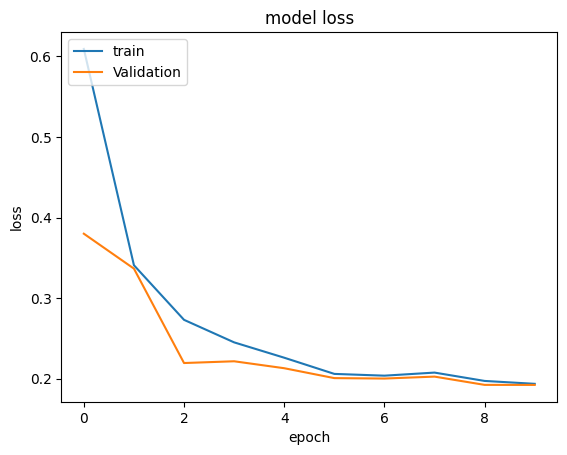

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

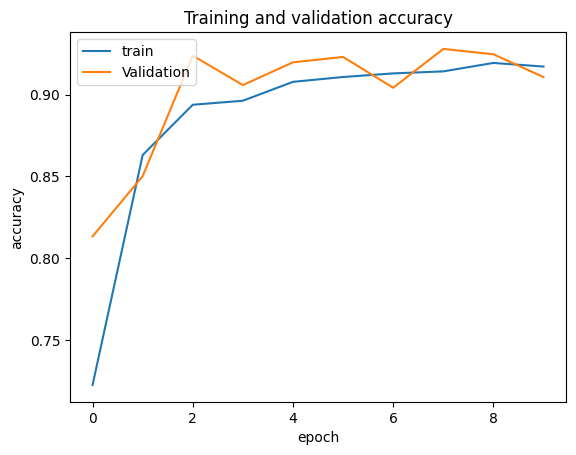

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

49/49 [==============================] - 1s 6ms/step
[[374 117   0]
 [ 96 436   0]
 [  0  27 510]]
0.8461538461538461
0.8477592662255522
              precision    recall  f1-score   support

           0       0.80      0.76      0.78       491
           1       0.75      0.82      0.78       532
           2       1.00      0.95      0.97       537

    accuracy                           0.85      1560
   macro avg       0.85      0.84      0.85      1560
weighted avg       0.85      0.85      0.85      1560



<Axes: >

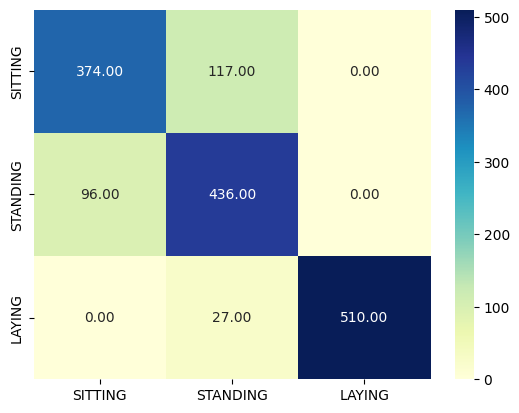

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['SITTING','STANDING','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# LSTM 2


In [ ]:
# Model 1
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(n_timesteps, n_features)))
model.add(Dropout(0.5))

model.add(LSTM(128))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))

model.add(Dense(n_outputs, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128, 128)          70656     
                                                                 
 dropout_1 (Dropout)         (None, 128, 128)          0         
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 3)                 387       
                                                                 
Total params: 219139 (856.01 KB)
Trainable params: 219

In [ ]:

# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
32/32 [==============================] - 5s 49ms/step - loss: 0.4730 - accuracy: 0.7974 - val_loss: 0.2534 - val_accuracy: 0.8878
Epoch 2/10
32/32 [==============================] - 1s 22ms/step - loss: 0.2472 - accuracy: 0.8957 - val_loss: 0.2302 - val_accuracy: 0.8984
Epoch 3/10
32/32 [==============================] - 1s 31ms/step - loss: 0.2281 - accuracy: 0.9080 - val_loss: 0.2363 - val_accuracy: 0.8894
Epoch 4/10
32/32 [==============================] - 1s 22ms/step - loss: 0.2137 - accuracy: 0.9115 - val_loss: 0.2131 - val_accuracy: 0.8984
Epoch 5/10
32/32 [==============================] - 1s 21ms/step - loss: 0.2085 - accuracy: 0.9139 - val_loss: 0.1919 - val_accuracy: 0.9230
Epoch 6/10
32/32 [==============================] - 1s 22ms/step - loss: 0.2180 - accuracy: 0.9063 - val_loss: 0.2120 - val_accuracy: 0.9247
Epoch 7/10
32/32 [==============================] - 1s 24ms/step - loss: 0.2117 - accuracy: 0.9120 - val_loss: 0.2103 - val_accuracy: 0.8984
Epoch 8/10
32

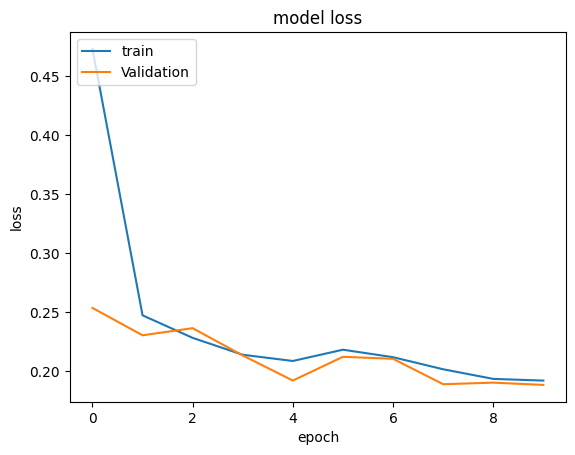

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

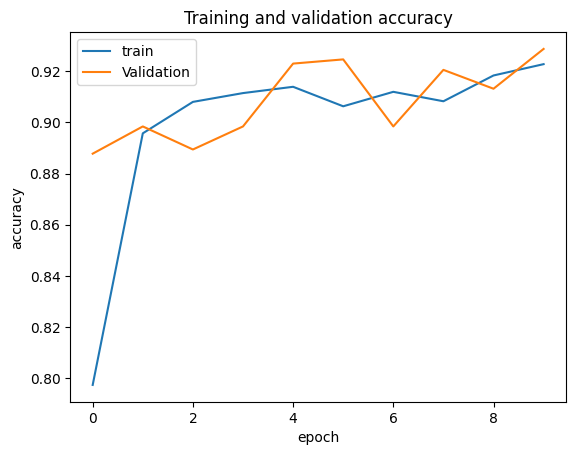

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

49/49 [==============================] - 1s 8ms/step
[[409  82   0]
 [104 428   0]
 [  0  27 510]]
0.8634615384615385
0.8648640001040838
              precision    recall  f1-score   support

           0       0.80      0.83      0.81       491
           1       0.80      0.80      0.80       532
           2       1.00      0.95      0.97       537

    accuracy                           0.86      1560
   macro avg       0.86      0.86      0.86      1560
weighted avg       0.87      0.86      0.86      1560



<Axes: >

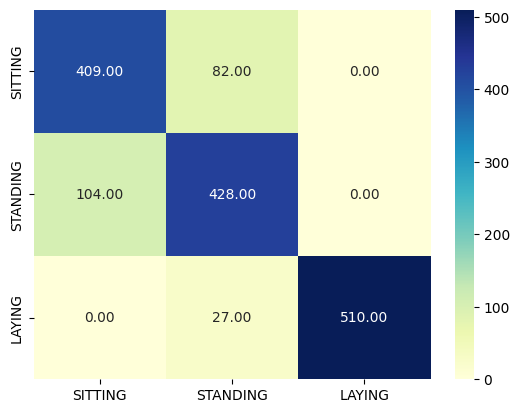

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['SITTING','STANDING','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# LSTM 3

In [ ]:
# Model 1
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(n_timesteps, n_features)))
model.add(Dropout(0.5))

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))

model.add(LSTM(128))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))

model.add(Dense(n_outputs, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 128, 128)          70656     
                                                                 
 dropout_3 (Dropout)         (None, 128, 128)          0         
                                                                 
 lstm_4 (LSTM)               (None, 128, 128)          131584    
                                                                 
 dropout_4 (Dropout)         (None, 128, 128)          0         
                                                                 
 lstm_5 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 128)              

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
32/32 [==============================] - 8s 83ms/step - loss: 0.5009 - accuracy: 0.7519 - val_loss: 0.2548 - val_accuracy: 0.8927
Epoch 2/10
32/32 [==============================] - 1s 35ms/step - loss: 0.2286 - accuracy: 0.9014 - val_loss: 0.2101 - val_accuracy: 0.8952
Epoch 3/10
32/32 [==============================] - 1s 34ms/step - loss: 0.2529 - accuracy: 0.9036 - val_loss: 0.2414 - val_accuracy: 0.8862
Epoch 4/10
32/32 [==============================] - 1s 32ms/step - loss: 0.2317 - accuracy: 0.9056 - val_loss: 0.2115 - val_accuracy: 0.9263
Epoch 5/10
32/32 [==============================] - 1s 32ms/step - loss: 0.2089 - accuracy: 0.9142 - val_loss: 0.1949 - val_accuracy: 0.9140
Epoch 6/10
32/32 [==============================] - 1s 33ms/step - loss: 0.2187 - accuracy: 0.9039 - val_loss: 0.2241 - val_accuracy: 0.9279
Epoch 7/10
32/32 [==============================] - 1s 34ms/step - loss: 0.2071 - accuracy: 0.9166 - val_loss: 0.1897 - val_accuracy: 0.9255
Epoch 8/10
32

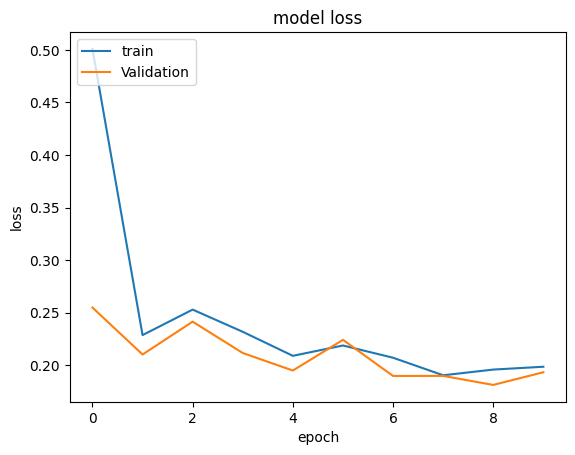

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

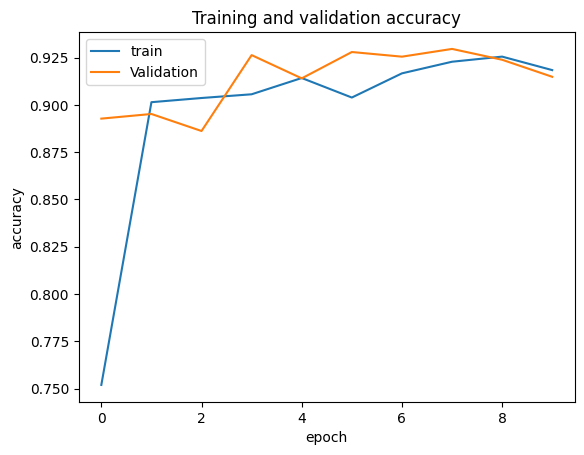

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

49/49 [==============================] - 1s 9ms/step
[[427  64   0]
 [124 408   0]
 [  0  27 510]]
0.8621794871794872
0.8632203181210452
              precision    recall  f1-score   support

           0       0.77      0.87      0.82       491
           1       0.82      0.77      0.79       532
           2       1.00      0.95      0.97       537

    accuracy                           0.86      1560
   macro avg       0.86      0.86      0.86      1560
weighted avg       0.87      0.86      0.86      1560



<Axes: >

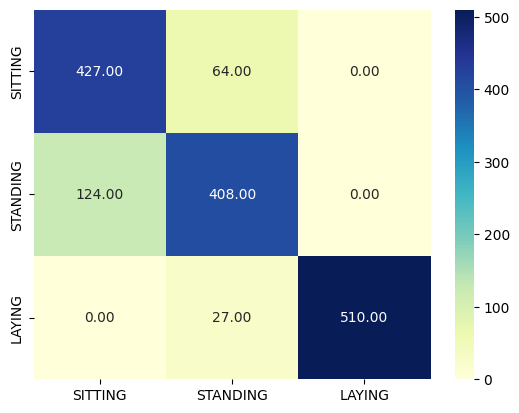

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['SITTING','STANDING','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# LSTM4

In [ ]:
# Model 1
model = Sequential()
model.add(LSTM(128, return_sequences=True , input_shape=(n_timesteps, n_features)))
model.add(Dropout(0.5))

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(128))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))

model.add(Dense(n_outputs, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 128, 128)          70656     
                                                                 
 dropout_6 (Dropout)         (None, 128, 128)          0         
                                                                 
 lstm_7 (LSTM)               (None, 128, 128)          131584    
                                                                 
 dropout_7 (Dropout)         (None, 128, 128)          0         
                                                                 
 lstm_8 (LSTM)               (None, 128, 128)          131584    
                                                                 
 dropout_8 (Dropout)         (None, 128, 128)          0         
                                                                 
 lstm_9 (LSTM)               (None, 128)              

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
32/32 [==============================] - 11s 87ms/step - loss: 0.5003 - accuracy: 0.7819 - val_loss: 0.2642 - val_accuracy: 0.8812
Epoch 2/10
32/32 [==============================] - 1s 44ms/step - loss: 0.2305 - accuracy: 0.8977 - val_loss: 0.2131 - val_accuracy: 0.8870
Epoch 3/10
32/32 [==============================] - 1s 44ms/step - loss: 0.3135 - accuracy: 0.8815 - val_loss: 0.2849 - val_accuracy: 0.9230
Epoch 4/10
32/32 [==============================] - 1s 43ms/step - loss: 0.2516 - accuracy: 0.9031 - val_loss: 0.2402 - val_accuracy: 0.9083
Epoch 5/10
32/32 [==============================] - 1s 43ms/step - loss: 0.2433 - accuracy: 0.9016 - val_loss: 0.2260 - val_accuracy: 0.8837
Epoch 6/10
32/32 [==============================] - 1s 45ms/step - loss: 0.2044 - accuracy: 0.9139 - val_loss: 0.1900 - val_accuracy: 0.9263
Epoch 7/10
32/32 [==============================] - 1s 46ms/step - loss: 0.2100 - accuracy: 0.9174 - val_loss: 0.2514 - val_accuracy: 0.8853
Epoch 8/10
3

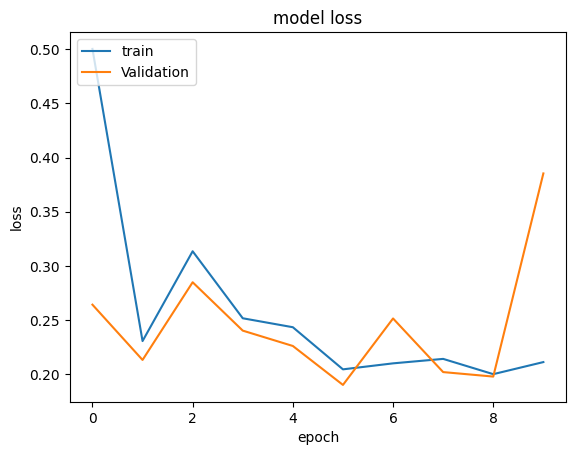

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

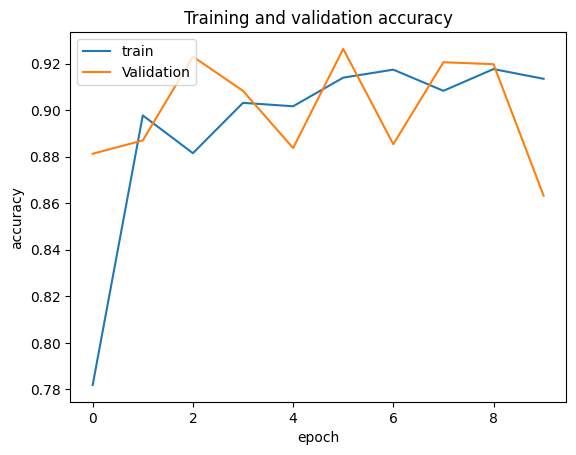

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

49/49 [==============================] - 2s 12ms/step
[[435  50   6]
 [139 393   0]
 [ 19   0 518]]
0.8628205128205129
0.863646765665271
              precision    recall  f1-score   support

           0       0.73      0.89      0.80       491
           1       0.89      0.74      0.81       532
           2       0.99      0.96      0.98       537

    accuracy                           0.86      1560
   macro avg       0.87      0.86      0.86      1560
weighted avg       0.87      0.86      0.86      1560



<Axes: >

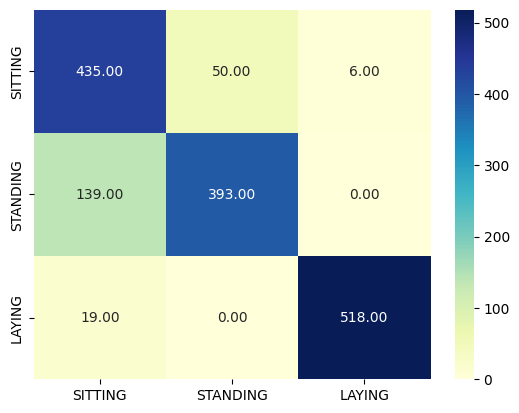

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['SITTING','STANDING','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# LSTM5

In [16]:
# Model 1
model = Sequential()
model.add(LSTM(128, return_sequences=True , input_shape=(n_timesteps, n_features)))
model.add(Dropout(0.5))

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))

model.add(LSTM(128))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))

model.add(Dense(n_outputs, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128, 128)          70656     
                                                                 
 dropout (Dropout)           (None, 128, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 128, 128)          131584    
                                                                 
 dropout_1 (Dropout)         (None, 128, 128)          0         
                                                                 
 lstm_2 (LSTM)               (None, 128, 128)          131584    
                                                                 
 dropout_2 (Dropout)         (None, 128, 128)          0         
                                                                 
 lstm_3 (LSTM)               (None, 128, 128)          1

In [17]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
32/32 [==============================] - 20s 106ms/step - loss: 0.6298 - accuracy: 0.7074 - val_loss: 0.4648 - val_accuracy: 0.7371
Epoch 2/10
32/32 [==============================] - 2s 47ms/step - loss: 0.3776 - accuracy: 0.8220 - val_loss: 0.2731 - val_accuracy: 0.8968
Epoch 3/10
32/32 [==============================] - 2s 47ms/step - loss: 0.2695 - accuracy: 0.8871 - val_loss: 0.2288 - val_accuracy: 0.9140
Epoch 4/10
32/32 [==============================] - 2s 48ms/step - loss: 0.2203 - accuracy: 0.9181 - val_loss: 0.2177 - val_accuracy: 0.8943
Epoch 5/10
32/32 [==============================] - 2s 48ms/step - loss: 0.2442 - accuracy: 0.9058 - val_loss: 0.2491 - val_accuracy: 0.8829
Epoch 6/10
32/32 [==============================] - 2s 48ms/step - loss: 0.2354 - accuracy: 0.8962 - val_loss: 0.2764 - val_accuracy: 0.8829
Epoch 7/10
32/32 [==============================] - 2s 53ms/step - loss: 0.2736 - accuracy: 0.9088 - val_loss: 0.2259 - val_accuracy: 0.9124
Epoch 8/10


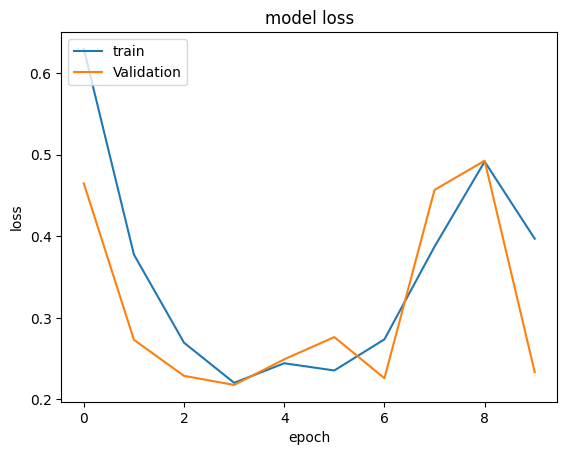

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

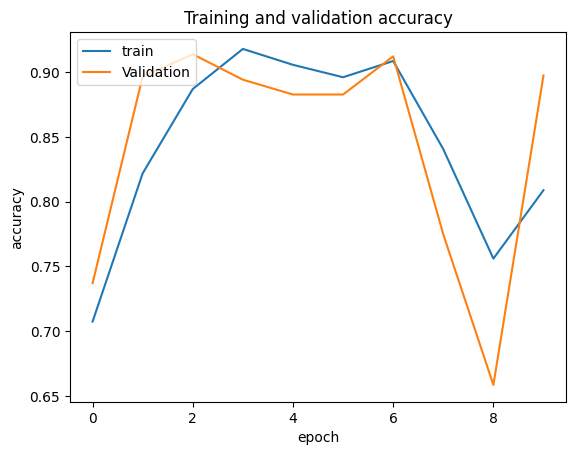

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

49/49 [==============================] - 2s 16ms/step
[[376 115   0]
 [ 97 435   0]
 [  0   0 537]]
0.8641025641025641
0.8639641974339898
              precision    recall  f1-score   support

           0       0.79      0.77      0.78       491
           1       0.79      0.82      0.80       532
           2       1.00      1.00      1.00       537

    accuracy                           0.86      1560
   macro avg       0.86      0.86      0.86      1560
weighted avg       0.86      0.86      0.86      1560



<Axes: >

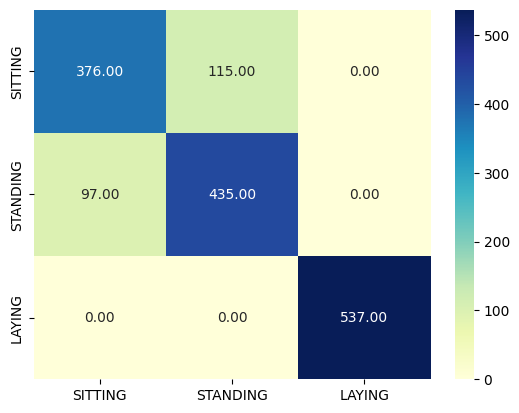

In [20]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['SITTING','STANDING','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')